# Random Forest: classify SNOT22 group based on initial microbiota

In [ ]:
%pip install pandas scikit-learn matplotlib seaborn markupsafe pygments

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [9]:
os.chdir(os.path.expanduser("~/Documents/Collaborations/sinusite_edwin/data"))

In [3]:
# Load data
## Load T0 relative abundance data
abund = pd.read_csv("Abund_by_Timepoint_4_Corr_T0.tsv", sep="\t", index_col=0)
abund.index.name = "ID_Sample"
abund.reset_index(inplace=True)  # make the ID a column

## Load metadata 
meta = pd.read_csv("metadata_filtered_Diversity.tsv", sep="\t")  

# Merge with metadata
merged = pd.merge(abund, meta, on="ID_Sample")
merged["SNOT22_group"] = merged["SNOT22"].apply(lambda x: 1 if x > 20 else 0) # group based on SNOT22
print(merged.head())

     ID_Sample  Anaerococcus  Corynebacterium  Cutibacterium  Dolosigranulum  \
0  0088303G_T0      0.601142         5.680794       0.150286       14.938383   
1  0110059G_T0     11.048527         0.519931       5.892548        6.152513   
2  0130765A_T0     10.679612         0.825243       1.165049        0.048544   
3  0207720E_T0      0.765184         0.000000       0.191296        0.119560   
4  0236549G_T0      0.718391        25.646552       0.862069        2.514368   

   Finegoldia  Haemophilus  Incertae Sedis  Peptoniphilus  Porphyromonas  ...  \
0    0.811542     0.180343        1.172227       0.721371       0.120228  ...   
1    5.632582     2.729636        0.476603      21.490468       0.043328  ...   
2    5.825243     1.796117        1.262136      10.776699       0.000000  ...   
3    0.071736     0.000000        0.119560       0.286944       0.000000  ...   
4    0.143678     0.000000        0.143678       0.431034       0.000000  ...   

   Sex   Age  Atopic_Symptoms  A

In [4]:
# Preprocess before making the model
## Split data into independent (X) and dependent (y) variables 
metadata_cols = [
    "ID_Sample", "SNOT22", "SNOT22_group", "ClinicCtrl", "SNOT22nasal", 
    "LK_Total", "LK_Secret", "Final_LundMackay", "nreads", "Timepoint",
    "AntUse", "Cortuse", "Patient", "Filename", "Sex", "Age", 
    "Atopic_Symptoms", "Asthma", "NSAID_Intolerance", 
    "Total_IgE", "Blood_Eosinophilia", "Tissue_Eosinophilia"
] 
X = merged.drop(columns=metadata_cols)
y = merged["SNOT22_group"]  # target = group 0 or 1

## Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)

In [5]:
print(X.head())
print(y.head())

   Anaerococcus  Corynebacterium  Cutibacterium  Dolosigranulum  Finegoldia  \
0      0.601142         5.680794       0.150286       14.938383    0.811542   
1     11.048527         0.519931       5.892548        6.152513    5.632582   
2     10.679612         0.825243       1.165049        0.048544    5.825243   
3      0.765184         0.000000       0.191296        0.119560    0.071736   
4      0.718391        25.646552       0.862069        2.514368    0.143678   

   Haemophilus  Incertae Sedis  Peptoniphilus  Porphyromonas  Pseudomonas  \
0     0.180343        1.172227       0.721371       0.120228     0.060114   
1     2.729636        0.476603      21.490468       0.043328     3.466205   
2     1.796117        1.262136      10.776699       0.000000    14.708738   
3     0.000000        0.119560       0.286944       0.000000     0.526064   
4     0.000000        0.143678       0.431034       0.000000     5.459770   

   ...  Prevotella  Serratia  Achromobacter  Granulicatella  M

In [6]:
# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, random_state=1234)
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

Confusion Matrix:


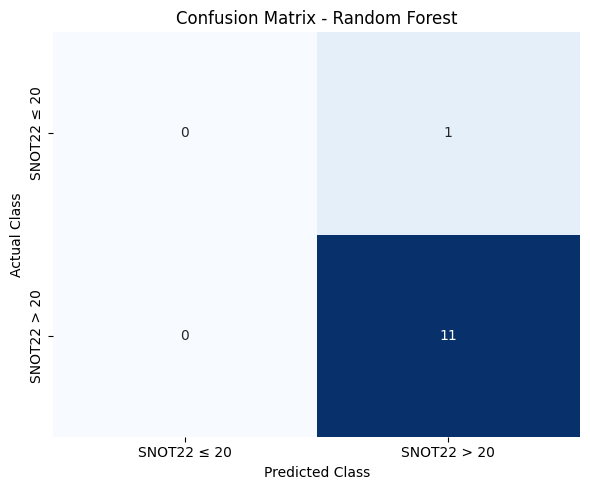


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      1.00      0.96        11

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12


Accuracy: 0.92


In [7]:
# Evaluate the model
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred) # generate conf matrix and visualize it in a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'],
            yticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'])

plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")

ROC AUC Score: 0.68


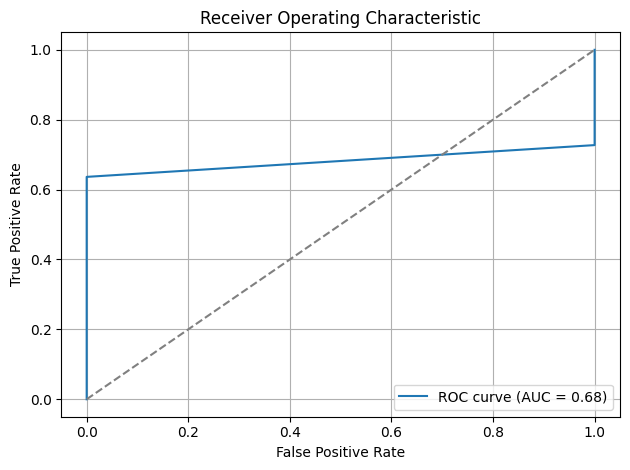

In [15]:
# Plot a ROC curve and calculate the area under it
y_proba = rf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Improving model: 
Train a model only on the T0 microbiota (pre-surgery), then test its generalizability by predicting the SNOT22 group at later timepoints (T1, T3, T6, T12).

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir(os.path.expanduser("~/Documents/Collaborations/sinusite_edwin/data"))

In [28]:
# === 1. Load T0 data (training set) ===
abund_T0 = pd.read_csv("Abund_by_Timepoint_4_Corr_T0.tsv", sep="\t", index_col=0)
abund_T0.index.name = "ID_Sample"
abund_T0.reset_index(inplace=True)

meta = pd.read_csv("metadata_filtered_Diversity.tsv", sep="\t")

merged_T0 = pd.merge(abund_T0, meta, on="ID_Sample")
merged_T0["SNOT22_group"] = merged_T0["SNOT22"].apply(lambda x: 1 if x > 20 else 0)

# Prepare features and labels
metadata_cols = [
    "ID_Sample", "SNOT22", "SNOT22_group", "ClinicCtrl", "SNOT22nasal", 
    "LK_Total", "LK_Secret", "Final_LundMackay", "nreads", "Timepoint",
    "AntUse", "Cortuse", "Patient", "Filename", "Sex", "Age", 
    "Atopic_Symptoms", "Asthma", "NSAID_Intolerance", 
    "Total_IgE", "Blood_Eosinophilia", "Tissue_Eosinophilia"
]
X_train = merged_T0.drop(columns=metadata_cols)
y_train = merged_T0["SNOT22_group"]

# Train the model
rf = RandomForestClassifier(n_estimators=500, random_state=1234)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1234)


=== Combined Post-Surgery Prediction ===
Accuracy: 0.39
ROC AUC: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.39      1.00      0.56        44

    accuracy                           0.39       113
   macro avg       0.19      0.50      0.28       113
weighted avg       0.15      0.39      0.22       113



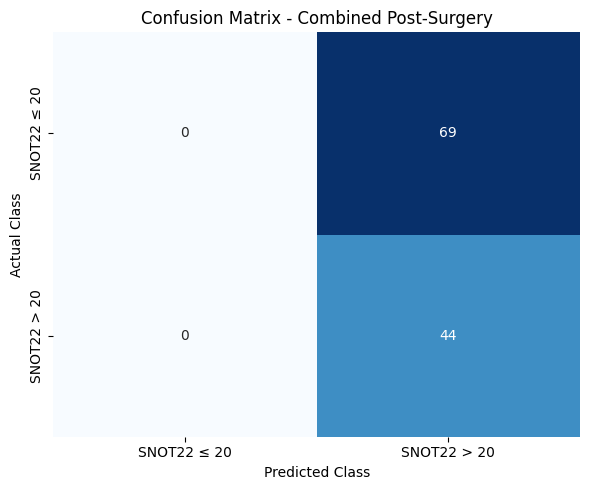

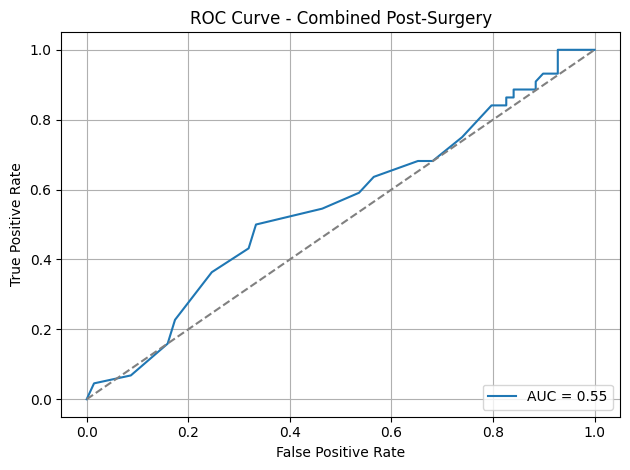

In [30]:
# === 2a. Combine all post-surgery timepoints into one test set ===
timepoints = ["T1", "T3", "T6", "T12"]
combined_test = []

for tp in timepoints:
    # Load and prep abundance data
    abund_tp = pd.read_csv(f"Abund_by_Timepoint_4_Corr_{tp}.tsv", sep="\t", index_col=0)
    abund_tp.index.name = "ID_Sample"
    abund_tp.reset_index(inplace=True)
    
    # Merge with metadata
    merged_tp = pd.merge(abund_tp, meta, on="ID_Sample")
    merged_tp["SNOT22_group"] = merged_tp["SNOT22"].apply(lambda x: 1 if x > 20 else 0)
    
    # Track timepoint (optional, for further analysis)
    merged_tp["Timepoint"] = tp
    
    combined_test.append(merged_tp)

# Concatenate all timepoints into a single test set
merged_all = pd.concat(combined_test, ignore_index=True)

# Define features and labels
X_test = merged_all.drop(columns=metadata_cols + ["Timepoint"])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)  # Align to training features
y_test = merged_all["SNOT22_group"]

# Predict
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluate
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n=== Combined Post-Surgery Prediction ===")
print("Accuracy:", round(acc, 2))
print("ROC AUC:", round(auc, 2))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'],
            yticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'])
plt.title('Confusion Matrix - Combined Post-Surgery')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Combined Post-Surgery")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


=== Predicting for T1 ===
Accuracy: 0.32
ROC AUC: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.32      1.00      0.49        10

    accuracy                           0.32        31
   macro avg       0.16      0.50      0.24        31
weighted avg       0.10      0.32      0.16        31



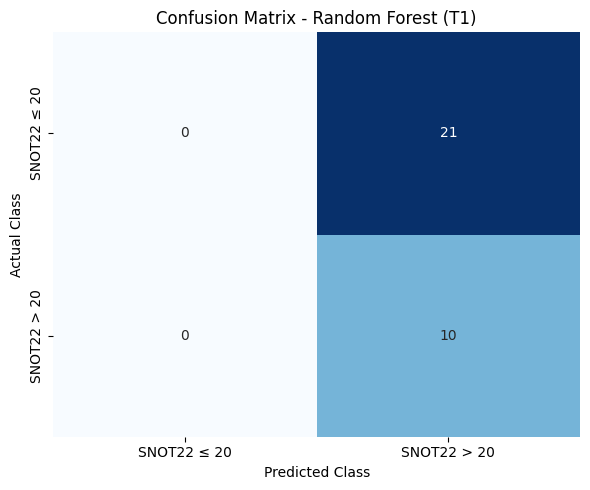

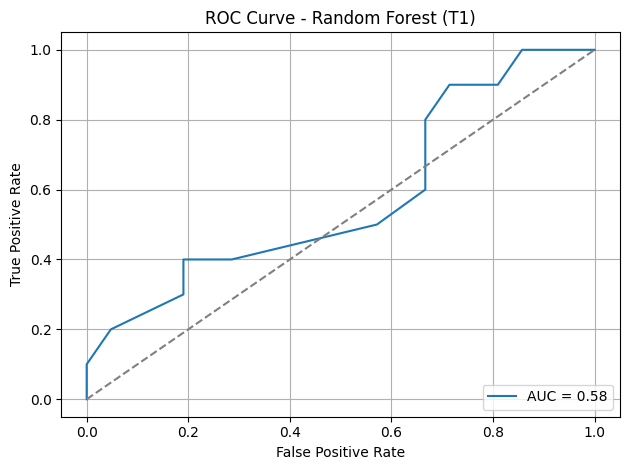


=== Predicting for T3 ===
Accuracy: 0.38
ROC AUC: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.38      1.00      0.55        13

    accuracy                           0.38        34
   macro avg       0.19      0.50      0.28        34
weighted avg       0.15      0.38      0.21        34



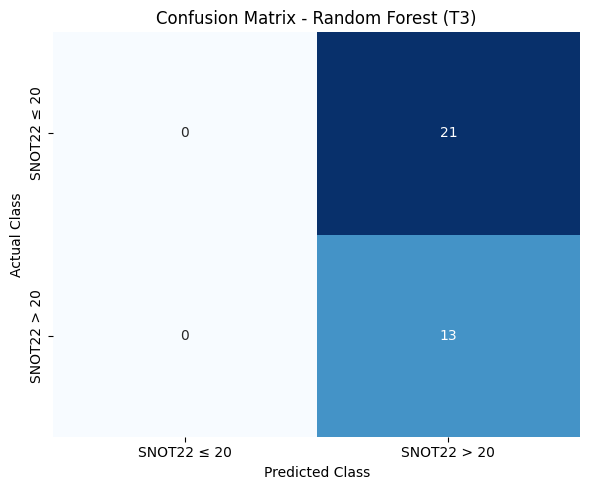

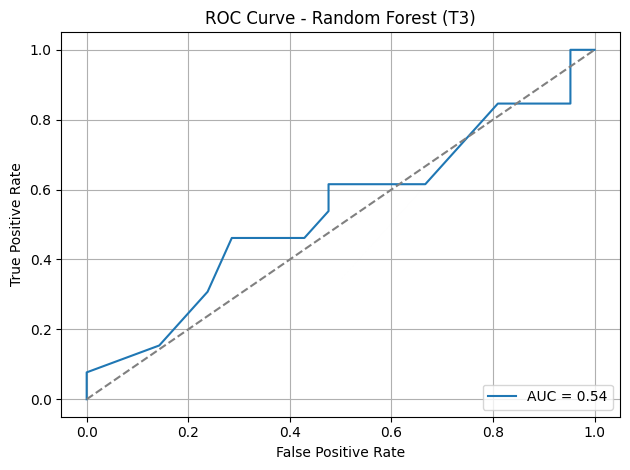


=== Predicting for T6 ===
Accuracy: 0.5
ROC AUC: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.50      1.00      0.67        14

    accuracy                           0.50        28
   macro avg       0.25      0.50      0.33        28
weighted avg       0.25      0.50      0.33        28



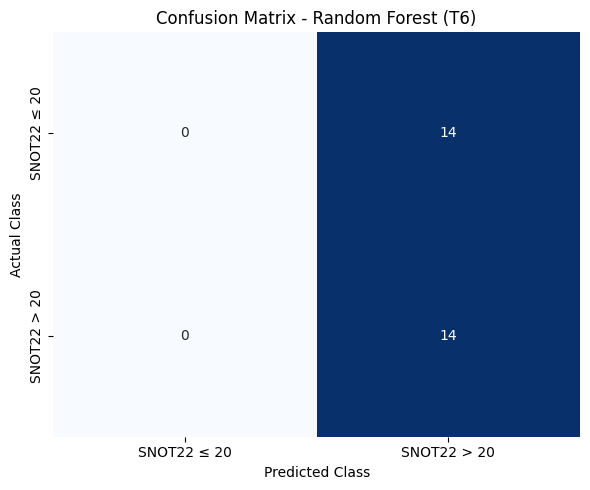

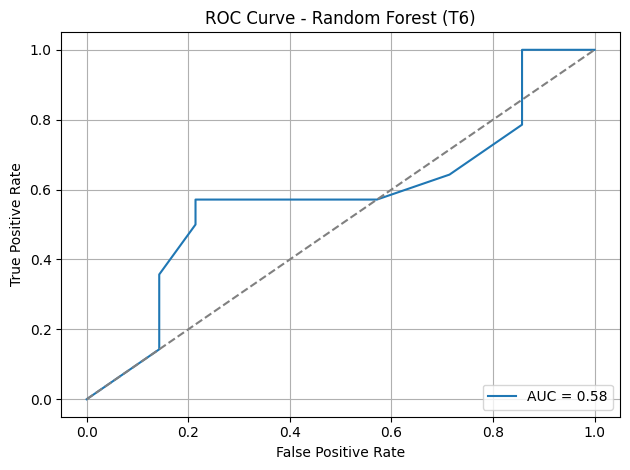


=== Predicting for T12 ===
Accuracy: 0.35
ROC AUC: 0.48
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.35      1.00      0.52         7

    accuracy                           0.35        20
   macro avg       0.17      0.50      0.26        20
weighted avg       0.12      0.35      0.18        20



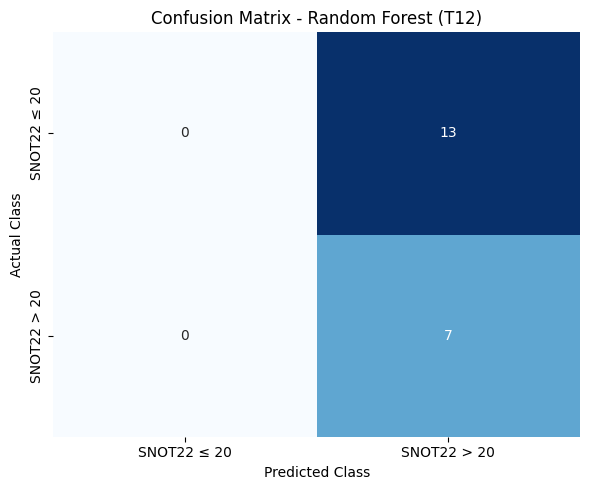

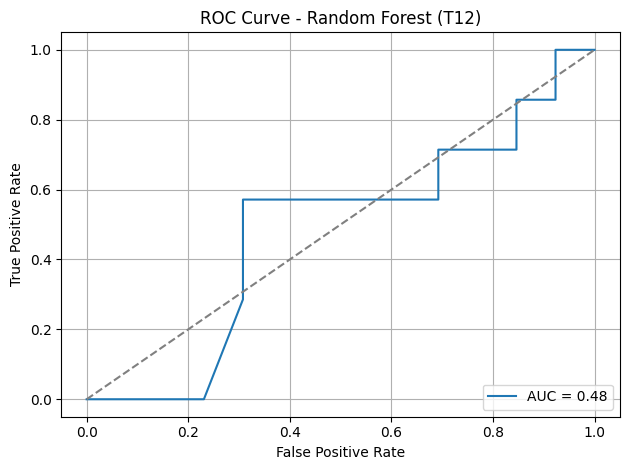

In [31]:
# === 2b. Test on each post-surgery timepoint ===
timepoints = ["T1", "T3", "T6", "T12"]

for tp in timepoints:
    print(f"\n=== Predicting for {tp} ===")
    
    # Load abundance data for the timepoint
    abund_tp = pd.read_csv(f"Abund_by_Timepoint_4_Corr_{tp}.tsv", sep="\t", index_col=0)
    abund_tp.index.name = "ID_Sample"
    abund_tp.reset_index(inplace=True)

    # Merge with metadata and clean
    merged_tp = pd.merge(abund_tp, meta, on="ID_Sample")
    merged_tp["SNOT22_group"] = merged_tp["SNOT22"].apply(lambda x: 1 if x > 20 else 0)

    X_test = merged_tp.drop(columns=metadata_cols)
    y_test = merged_tp["SNOT22_group"]

    # Predict
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print("Accuracy:", round(acc, 2))
    print("ROC AUC:", round(auc, 2))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # Confusion Matrix as Heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'],
                yticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'])
    plt.title(f'Confusion Matrix - Random Forest ({tp})')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - Random Forest ({tp})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [53]:
###### Using Clinic Control --> can't do, since there's no one in T0 with C, 
######## so the model won't be able to classify a microbiota profile as control

In [11]:
# Explore which features are more relevant in terms of predictibility
 ## then use these features for 


=== Post-Surgery Prediction (T3+T6+T12) ===
Accuracy: 0.41
ROC AUC: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.41      1.00      0.59        34

    accuracy                           0.41        82
   macro avg       0.21      0.50      0.29        82
weighted avg       0.17      0.41      0.24        82



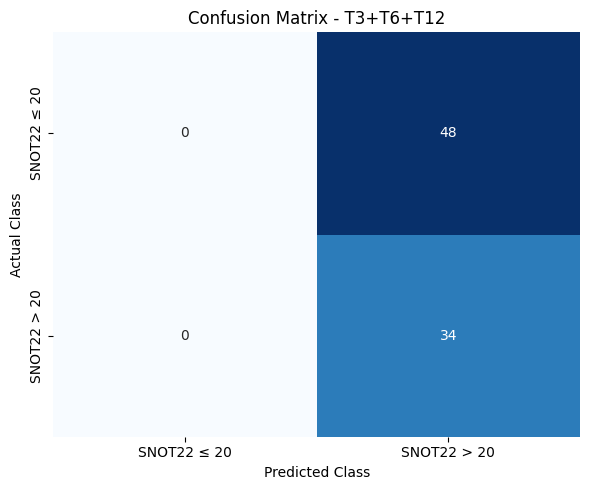

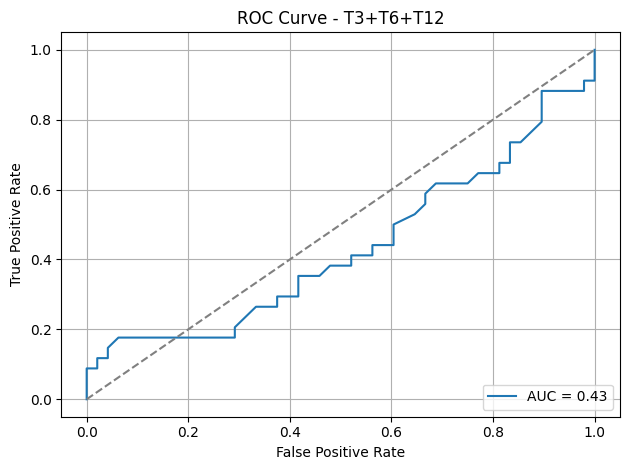

In [10]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
os.chdir(os.path.expanduser("~/Documents/Collaborations/sinusite_edwin/data"))

# Load metadata
meta = pd.read_csv("metadata_filtered_Diversity.tsv", sep="\t")

# === 1. Load T0 + T1 as training set ===
timepoints_train = ["T0", "T1"]
train_frames = []

for tp in timepoints_train:
    abund = pd.read_csv(f"Abund_by_Timepoint_4_Corr_{tp}.tsv", sep="\t", index_col=0)
    abund.index.name = "ID_Sample"
    abund.reset_index(inplace=True)

    merged = pd.merge(abund, meta, on="ID_Sample")
    merged["SNOT22_group"] = merged["SNOT22"].apply(lambda x: 1 if x > 20 else 0)
    merged["Timepoint"] = tp
    train_frames.append(merged)

merged_train = pd.concat(train_frames, ignore_index=True)

# === 2. Prepare training features ===
metadata_cols = [
    "ID_Sample", "SNOT22", "SNOT22_group", "ClinicCtrl", "SNOT22nasal", 
    "LK_Total", "LK_Secret", "Final_LundMackay", "nreads", "Timepoint",
    "AntUse", "Cortuse", "Patient", "Filename", "Sex", "Age", 
    "Atopic_Symptoms", "Asthma", "NSAID_Intolerance", 
    "Total_IgE", "Blood_Eosinophilia", "Tissue_Eosinophilia"
]

X_train = merged_train.drop(columns=metadata_cols)
y_train = merged_train["SNOT22_group"]

# Train the classifier
rf = RandomForestClassifier(n_estimators=500, random_state=1234)
rf.fit(X_train, y_train)

# === 3. Use T3, T6, T12 as test set ===
timepoints_test = ["T3", "T6", "T12"]
test_frames = []

for tp in timepoints_test:
    abund = pd.read_csv(f"Abund_by_Timepoint_4_Corr_{tp}.tsv", sep="\t", index_col=0)
    abund.index.name = "ID_Sample"
    abund.reset_index(inplace=True)

    merged = pd.merge(abund, meta, on="ID_Sample")
    merged["SNOT22_group"] = merged["SNOT22"].apply(lambda x: 1 if x > 20 else 0)
    merged["Timepoint"] = tp
    test_frames.append(merged)

merged_test = pd.concat(test_frames, ignore_index=True)

# === 4. Prepare testing features ===
X_test = merged_test.drop(columns=metadata_cols + ["Timepoint"])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
y_test = merged_test["SNOT22_group"]

# === 5. Predict and evaluate ===
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n=== Post-Surgery Prediction (T3+T6+T12) ===")
print("Accuracy:", round(acc, 2))
print("ROC AUC:", round(auc, 2))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'],
            yticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'])
plt.title('Confusion Matrix - T3+T6+T12')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - T3+T6+T12")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Training set class distribution:
SNOT22_group
1    0.661765
0    0.338235
Name: proportion, dtype: float64

Test set class distribution:
SNOT22_group
0    0.585366
1    0.414634
Name: proportion, dtype: float64


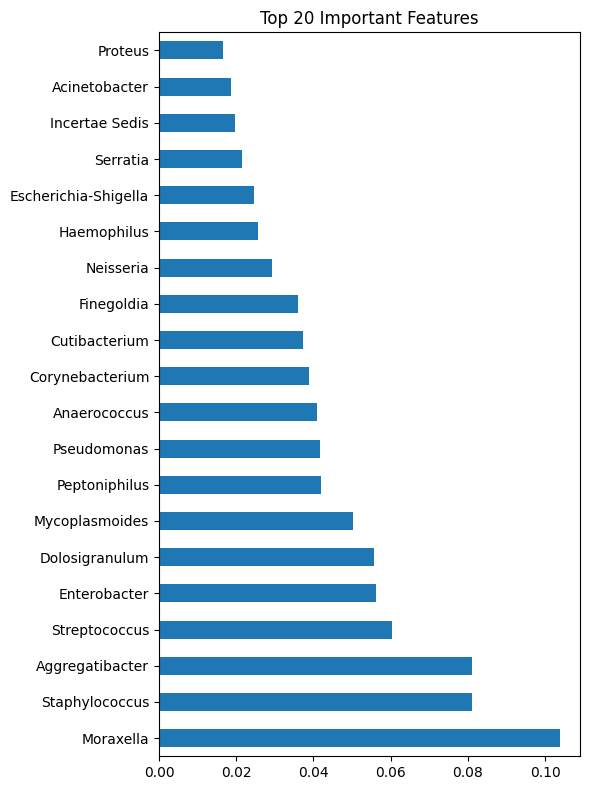

In [13]:
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(20)
top_features.plot(kind='barh', figsize=(6,8))
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()


In [15]:
clinical_cols = ["Age", "Sex", "Asthma", "NSAID_Intolerance", "Atopic_Symptoms"]
# Ensure these are properly encoded
merged_train["Sex"] = merged_train["Sex"].map({"M": 0, "F": 1})
merged_test["Sex"] = merged_test["Sex"].map({"M": 0, "F": 1})

X_train_combined = pd.concat([X_train.reset_index(drop=True), merged_train[clinical_cols].reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test.reset_index(drop=True), merged_test[clinical_cols].reset_index(drop=True)], axis=1)

rf_combined = RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=1234)
rf_combined.fit(X_train_combined, y_train)
y_pred_combined = rf_combined.predict(X_test_combined)
print("Accuracy (with clinical):", accuracy_score(y_test, y_pred_combined))

Accuracy (with clinical): 0.4146341463414634


### New Objective: Predict Individual SNOT22 Improvement (ΔSNOT22 > 9)

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import os
os.chdir(os.path.expanduser("~/Documents/Collaborations/sinusite_edwin/data"))

# === Parameters ===
timepoints = ["T0", "T1", "T3", "T6", "T12"]
abund_all = []
meta = pd.read_csv("metadata_filtered_Diversity.tsv", sep="\t")

# === 1. Load and combine abundance data ===
for tp in timepoints:
    abund = pd.read_csv(f"Abund_by_Timepoint_4_Corr_{tp}.tsv", sep="\t", index_col=0)
    abund.index.name = "ID_Sample"
    abund.reset_index(inplace=True)
    
    abund["Timepoint"] = tp
    abund_all.append(abund)

abund_all = pd.concat(abund_all, ignore_index=True)
abund_merged = pd.merge(abund_all, meta, on="ID_Sample")

# Resolve the Timepoint column
abund_merged["Timepoint"] = abund_merged["Timepoint_x"]  # or Timepoint_y if you prefer
abund_merged = abund_merged.drop(columns=["Timepoint_x", "Timepoint_y"])

# === 2. Split microbiota features from metadata ===
metadata_cols = [
    "ID_Sample", "SNOT22", "SNOT22_group", "ClinicCtrl", "SNOT22nasal", 
    "LK_Total", "LK_Secret", "Final_LundMackay", "nreads", "Timepoint",
    "AntUse", "Cortuse", "Patient", "Filename", "Sex", "Age", 
    "Atopic_Symptoms", "Asthma", "NSAID_Intolerance", 
    "Total_IgE", "Blood_Eosinophilia", "Tissue_Eosinophilia"
]
feature_cols = [col for col in abund_merged.columns if col not in metadata_cols]

# === 3. Create T0–Tn delta and improvement label ===
paired_data = []

for patient_id in abund_merged["Patient"].unique():
    patient_data = abund_merged[abund_merged["Patient"] == patient_id]
    t0_row = patient_data[patient_data["Timepoint"] == "T0"]
    
    if t0_row.empty:
        continue
    
    X_T0 = t0_row[feature_cols].values[0]
    snot_T0 = t0_row["SNOT22"].values[0]
    
    for tp in ["T1", "T3", "T6", "T12"]:
        tn_row = patient_data[patient_data["Timepoint"] == tp]
        
        if tn_row.empty:
            continue
        
        X_Tn = tn_row[feature_cols].values[0]
        snot_Tn = tn_row["SNOT22"].values[0]
        
        delta_X = X_Tn - X_T0
        label = 1 if (snot_T0 - snot_Tn) > 9 else 0
        
        paired_data.append((delta_X, label))

# === 4. Convert to DataFrame and run classification ===
X = pd.DataFrame([x[0] for x in paired_data], columns=feature_cols)
y = pd.Series([x[1] for x in paired_data], name="Improved")

print("Total samples:", len(y))
print("Improvement class distribution:\n", y.value_counts())

# === 5. Train model ===
clf = RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=1234)
scores = cross_val_score(clf, X, y, cv=5, scoring="roc_auc")
print("\nCross-validated ROC AUC:", round(scores.mean(), 2))


Total samples: 99
Improvement class distribution:
 Improved
1    83
0    16
Name: count, dtype: int64

Cross-validated ROC AUC: 0.57


In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
auc = cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc')
print("Cross-validated ROC AUC:", round(auc.mean(), 2))


Cross-validated ROC AUC: 0.78


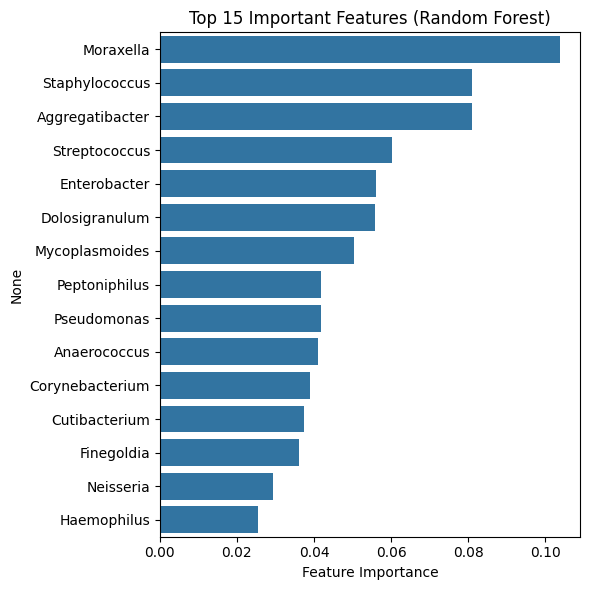

In [25]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(6, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

Total samples: 150

Top 15 features:
 Staphylococcus          0.072965
Corynebacterium         0.058090
Mycoplasmoides          0.057533
Streptococcus           0.049385
Pseudomonas             0.047203
Serratia                0.045638
Cutibacterium           0.045458
Peptoniphilus           0.045356
Finegoldia              0.044690
Anaerococcus            0.042963
Incertae Sedis          0.041105
Dolosigranulum          0.039408
Escherichia-Shigella    0.036507
Haemophilus             0.033944
Enterobacter            0.029246
dtype: float64

Cross-validated ROC AUC scores: [0.42857143 0.56473214 0.41964286 0.83482143 0.66222222]
Mean ROC AUC: 0.58 ± 0.16


/tmp/ipykernel_26302/1363190091.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


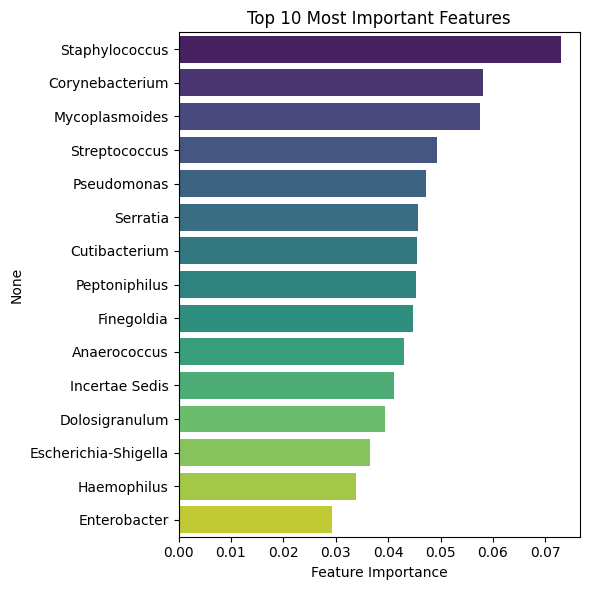

In [31]:
# === Load metadata ===
meta = pd.read_csv("metadata_filtered_Diversity.tsv", sep="\t")

# === Load and merge abundance data across all timepoints ===
timepoints = ["T0", "T1", "T3", "T6", "T12"]
train_frames = []

for tp in timepoints:
    abund = pd.read_csv(f"Abund_by_Timepoint_4_Corr_{tp}.tsv", sep="\t", index_col=0)
    abund.index.name = "ID_Sample"
    abund.reset_index(inplace=True)
    
    merged = pd.merge(abund, meta, on="ID_Sample")
    merged["SNOT22_group"] = merged["SNOT22"].apply(lambda x: 1 if x > 20 else 0)
    train_frames.append(merged)

# === Combine all into a training set ===
full_data = pd.concat(train_frames, ignore_index=True)
print("Total samples:", len(full_data))

# === Prepare feature matrix and labels ===
metadata_cols = [
    "ID_Sample", "SNOT22", "SNOT22_group", "ClinicCtrl", "SNOT22nasal", 
    "LK_Total", "LK_Secret", "Final_LundMackay", "nreads", "Timepoint_x", "Timepoint_y",
    "AntUse", "Cortuse", "Patient", "Filename", "Sex", "Age", 
    "Atopic_Symptoms", "Asthma", "NSAID_Intolerance", 
    "Total_IgE", "Blood_Eosinophilia", "Tissue_Eosinophilia"
]
X_all = full_data.drop(columns=metadata_cols, errors="ignore")
y_all = full_data["SNOT22_group"]

# Keep only numeric features (drop strings like 'T0')
X_all = X_all.select_dtypes(include=[np.number])

# === Initial full model to get feature importances ===
rf_full = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=1234)
rf_full.fit(X_all, y_all)

# Get top 15 features
importances = pd.Series(rf_full.feature_importances_, index=X_all.columns)
top_features = importances.sort_values(ascending=False).head(15)
print("\nTop 15 features:\n", top_features)

# Reduce dataset to top 15 features only
X_top10 = X_all[top_features.index]

# === Stratified cross-validation ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
rf_final = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=1234)

auc_scores = cross_val_score(rf_final, X_top10, y_all, cv=cv, scoring='roc_auc')

print(f"\nCross-validated ROC AUC scores: {auc_scores}")
print(f"Mean ROC AUC: {auc_scores.mean():.2f} ± {auc_scores.std():.2f}")

# === Optional: Visualize feature importance ===
plt.figure(figsize=(6, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title("Top 10 Most Important Features")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


Cross-validated Accuracy: 0.55


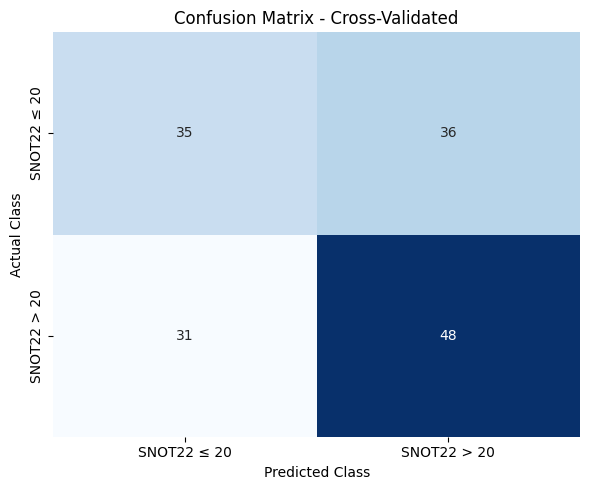

Cross-validated ROC AUC: 0.58


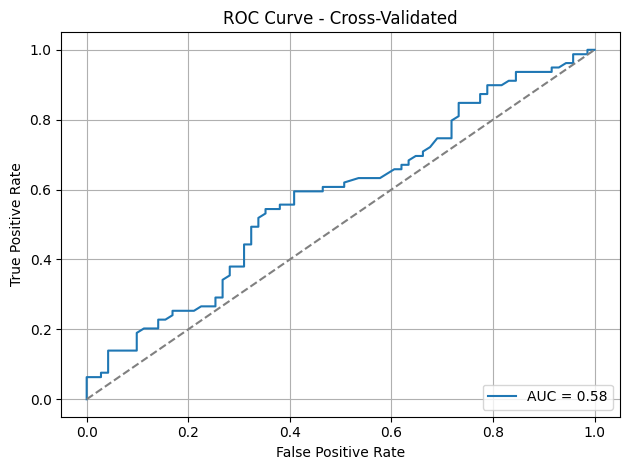

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
import numpy as np

# Initialize CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
rf_final = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=1234)

# Arrays to collect true labels, predicted probs and preds
y_true_all = []
y_pred_all = []
y_proba_all = []

for train_idx, test_idx in cv.split(X_top10, y_all):
    X_train, X_test = X_top10.iloc[train_idx], X_top10.iloc[test_idx]
    y_train, y_test = y_all.iloc[train_idx], y_all.iloc[test_idx]

    rf_final.fit(X_train, y_train)
    y_pred = rf_final.predict(X_test)
    y_proba = rf_final.predict_proba(X_test)[:, 1]

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_proba_all.extend(y_proba)

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_proba_all = np.array(y_proba_all)

# Accuracy
acc = accuracy_score(y_true_all, y_pred_all)
print(f"\nCross-validated Accuracy: {acc:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'],
            yticklabels=['SNOT22 ≤ 20', 'SNOT22 > 20'])
plt.title('Confusion Matrix - Cross-Validated')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

# ROC AUC
auc = roc_auc_score(y_true_all, y_proba_all)
print(f"Cross-validated ROC AUC: {auc:.2f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_all, y_proba_all)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Cross-Validated")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

# Store confusion matrices and accuracies
conf_matrices = {}
accuracies = {}

# Loop over each timepoint
for tp in timepoints:
    # Subset data
    tp_data = full_data[full_data["Timepoint_x"] == tp]
    X_tp = tp_data[top_features.index].select_dtypes(include=[np.number])
    y_tp = tp_data["SNOT22_group"]

    # Train-test split within timepoint
    if len(y_tp.unique()) < 2:
        print(f"Skipping {tp} — only one class present.")
        continue

    # Use StratifiedKFold for each timepoint (can be replaced with simple split if too few samples)
    cv_tp = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    y_true_tp = []
    y_pred_tp = []

    for train_idx, test_idx in cv_tp.split(X_tp, y_tp):
        X_train, X_test = X_tp.iloc[train_idx], X_tp.iloc[test_idx]
        y_train, y_test = y_tp.iloc[train_idx], y_tp.iloc[test_idx]

        rf_final.fit(X_train, y_train)
        y_pred = rf_final.predict(X_test)

        y_true_tp.extend(y_test)
        y_pred_tp.extend(y_pred)

    # Compute and store confusion matrix
    cm = confusion_matrix(y_true_tp, y_pred_tp)
    acc = accuracy_score(y_true_tp, y_pred_tp)
    conf_matrices[tp] = cm
    accuracies[tp] = acc

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["SNOT22 ≤ 20", "SNOT22 > 20"],
                yticklabels=["SNOT22 ≤ 20", "SNOT22 > 20"])
    plt.title(f"Confusion Matrix - {tp} (Acc = {acc:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

KeyError: 'Timepoint_x'